In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


In [3]:
import sys,os

sys.path.append('/home/alvinma/Desktop/mlfinlab')

sys.path.append('/home/alvinma/Desktop/mplfinance/src')


sys.path.append('/home/alvinma/Desktop/private-hft')
sys.path.append('../../ailabx-master')
from mlfinlab.filters import filters
from mlfinlab.labeling import labeling
# from mlfinlab.util import utils

/home/alvinma/Desktop/mlfinlab/mlfinlab/util/fast_ewma.py:14: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((float64[:], int64), nopython=False, nogil=True)


In [4]:
from utils.binance_load_data import *
from utils.mlfinlab_expand  import *
from utils.afml_backtest import *
from utils.clickhouse_utils  import *
from utils.analysis_data import *
from utils.twin_range_filter import *
from utils.kalman_filter import *
from utils.full_perona_malik import *
import imp
imp.reload(sys.modules['utils.binance_load_data'])
imp.reload(sys.modules['utils.mlfinlab_expand'])
imp.reload(sys.modules['utils.afml_backtest'])
imp.reload(sys.modules['utils.clickhouse_utils'])
imp.reload(sys.modules['utils.analysis_data'])
imp.reload(sys.modules['utils.twin_range_filter'])
imp.reload(sys.modules['utils.kalman_filter'])
imp.reload(sys.modules['utils.full_perona_malik'])
imp.reload(sys.modules['mlfinlab.features.fracdiff'])


/home/alvinma/Desktop/private-hft/utils/binance_load_data.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alvinma/Desktop/private-hft/utils/binance_load_data.py:18: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/tmp/ipykernel_232779/2017253069.py:9: DeprecationWarning:

the imp module is deprecated in favour of importlib; see

<module 'mlfinlab.features.fracdiff' from '/home/alvinma/Desktop/mlfinlab/mlfinlab/features/fracdiff.py'>

In [5]:
from mlfinlab.filters import filters
from mlfinlab.labeling import labeling


In [6]:
from mlfinlab.sampling import concurrent
from mlfinlab.sampling import bootstrapping
from mlfinlab.util import multiprocess,get_daily_vol,get_minutes_vol,get_hours_vol

In [7]:
%matplotlib inline

In [8]:
def get_test_dollar_bars2(database,password,start_date,end_date,table_name = 'binance_futures_um_trades_btcusdt_dollar_1_20230620042939'):
    # connect to clickhouse
    client =ClickHouseDB(host='localhost', port = 9000,
                                        user='default', 
                                        password = password,
                                        database=database
                                        )
    client.connect()

    data = client.get_dataframes(table_name,['*'],start_dt=start_date,end_dt=end_date)

    print(data.head(3))
    #only keep          open     high      low    close  volume    cum_dollar_value  cum_ticks  cum_buy_volume
    data = data[['timestamp','open','high','low','close','volume','cum_dollar_value','cum_ticks','cum_buy_volume','tick_num']]
    #rename columns to  open     high      low    close  cum_vol   cum_dollar  cum_ticks  cum_buy_volume
    data = data.rename(columns={'timestamp':'date_time','volume':'cum_vol','cum_dollar_value':'cum_dollar','cum_ticks':'cum_ticks','cum_buy_volume':'cum_buy_volume'})
    data.set_index('date_time',inplace=True)
    #sort by index
    data.sort_index(inplace=True)
    # data.index = pd.to_datetime(data['timestamp'])
    # data = data.drop('timestamp', axis=1)
    # close_prices = data['close']

    print(f"数据量：{len(data)} memory usage: {data.memory_usage().sum()/1024**2} MB shape: {data.shape} time range: {data.index.min()} - {data.index.max()}")
    return data

In [9]:
import datetime as dt
from pytz import UTC
import getpass
from datetime import datetime

from utils.clickhouse_utils  import *

enable_load = True
#check file  data.pkl exist
if os.path.exists('data.pkl') and enable_load:
    data=pd.read_pickle('data.pkl')
    
else:

    password=getpass.getpass("请输入ClickHouse的密码：")
    database=input("请输入ClickHouse的数据库名字：")
    start_date = datetime(2020, 1, 1, 0, 0, 0, 0,UTC)
    end_date = datetime.now(UTC)

    data = get_test_dollar_bars(database,password,start_date,end_date,table_name='binance_futures_um_trades_btcusdt_dollar_5_20230620094918')
    data.head()


    print(f"数据量：{len(data)} memory usage: {data.memory_usage().sum()/1024**2} MB shape: {data.shape} time range: {data.index.min()} - {data.index.max()}")
    data

    #if data.pkl exist

    #data save to pickle
    data.to_pickle('data.pkl')

#prepare data to agg
data.reset_index(inplace=True)
#rename column date_time to timestamp
data.rename(columns={'date_time':'timestamp','cum_vol':'volume','cum_dollar':'cum_dollar_value'},inplace=True)
data['tick_num'] = data['cum_ticks'].cumsum()
data.head()

,timestamp,open,high,low,close,volume,cum_dollar_value,cum_ticks,cum_buy_volume,tick_num
0,2020-02-01 00:01:19.206000+00:00,9364.50,9385.37,9364.50,9377.94,318.298,2.983939e+06,857,186.958,857
1,2020-02-01 00:04:22.250000+00:00,9377.73,9377.73,9357.42,9357.42,322.139,3.017649e+06,686,108.286,1543
2,2020-02-01 00:08:36.747000+00:00,9360.00,9369.54,9357.79,9369.31,321.935,3.014425e+06,538,166.672,2081
3,2020-02-01 00:11:41.273000+00:00,9368.66,9385.52,9366.21,9378.29,318.435,2.985428e+06,632,174.516,2713
4,2020-02-01 00:15:17.575000+00:00,9378.99,9392.54,9378.99,9388.43,317.850,2.982939e+06,554,176.976,3267


In [10]:
#agg

data_raw = data.copy()
data = dollar_bar_agg_mp(data_raw,scalar_step=5)
close_prices = data['close']
index_list = data.index.tolist()

# 计算相邻两个datetime之间的时间间隔并保存到列表中
time_intervals = [index_list[i + 1] - index_list[i] for i in range(len(index_list) - 1)]

# 将时间间隔转换为秒数，方便后续分析
time_intervals_seconds = [interval.total_seconds() for interval in time_intervals]

# quantile
print(pd.Series(time_intervals_seconds).quantile([0.1,0.2,0.3,0.4, 0.5,0.6,0.7,0.8, 0.9]))
print(pd.Series(time_intervals_seconds).describe())
print(f"shape: {data_raw.shape} time range: {data_raw.index.min()} - {data_raw.index.max()}")
print(f"shape: {data.shape} time range: {data.index.min()} - {data.index.max()}")



dup_group_id_first: [ 15231  30462  45693  60924  91387 106618]
dup_agg: (6, 55) aggregated_df.shape (121856, 55)
aggregated_df.drop: (121844, 55)
aggregated_df.concat: (121850, 55)
0.1     117.4620
0.2     231.9628
0.3     355.3318
0.4     495.2354
0.5     655.4350
0.6     846.4424
0.7    1079.4334
0.8    1383.4772
0.9    1871.8588
dtype: float64
count    121849.000000
mean        862.226378
std         789.623273
min           0.025000
25%         291.936000
50%         655.435000
75%        1217.728000
max       61300.782000
dtype: float64
shape: (609248, 10) time range: 0 - 609247
shape: (121850, 54) time range: 2020-02-01 00:15:17.575000+00:00 - 2023-05-31 23:58:59.558000+00:00


In [11]:
def cover_agg_data_to_local_format(data):
    data.reset_index(inplace=True)
    data.rename(columns={'timestamp':'date_time','volume':'cum_vol','cum_dollar_value':'cum_dollar'},inplace=True)
    data.set_index('date_time',inplace=True)
    data = data[['open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks']]
    return data



In [12]:
data = cover_agg_data_to_local_format(data)

In [13]:
import datatable as dt
def load_eth(
    data_path = '/home/alvinma/Desktop/ailabx-master/data/cypto/ethusdt/ETHUSDT-FEATURES-20210101000112-20230803235959.csv'
):
    data = dt.fread(data_path).to_pandas()
    print(f"shape {data.shape} time range: {data.index.min()} - {data.index.max()} memory usage: {data.memory_usage().sum()/1024**2} MB")
    data.set_index('date',inplace=True)
    print(data.columns.tolist())
    print_index_delta_describe(data)
    data = prepare_to_agg(data)
    data = dollar_bar_agg_mp(data,scalar_step=50)
    data = cover_agg_data_to_local_format(data)
    data = data[~data.index.duplicated(keep='first')]
    #sort by index
    data.sort_index(inplace=True)
    print(f"数据量：{len(data)} memory usage: {data.memory_usage().sum()/1024**2} MB shape: {data.shape} time range: {data.index.min()} - {data.index.max()}")
   
    return data



    

##### Define RSI 

In [14]:
# Compute RSI
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

def bbands(close_prices, window, no_of_stdev):
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [15]:
data = load_eth()

shape (3485043, 15) time range: 0 - 3485042 memory usage: 385.53725814819336 MB
['open', 'high', 'low', 'close', 'volume', 'vwap', 'symbol', 'ticks', 'buy_volume_rate', 'buy_dollar_rate', 'net_dollar_open', 'net_dollar_high', 'net_dollar_low', 'net_dollar_close']
                            time
count                    3485042
mean   0 days 00:00:23.428104154
std    0 days 00:00:30.381289162
min       0 days 00:00:00.000001
25%       0 days 00:00:04.163000
50%       0 days 00:00:12.873000
75%       0 days 00:00:30.905000
max       0 days 01:00:08.204000
dup_group_id_first: [ 8712 17425 26137 34850 43563 52275 60988]
dup_agg: (7, 55) aggregated_df.shape (69708, 55)
aggregated_df.drop: (69694, 55)
aggregated_df.concat: (69701, 55)
数据量：69701 memory usage: 3.988323211669922 MB shape: (69701, 7) time range: 2021-01-01 01:14:24.963000 - 2023-08-03 23:59:59.828000


In [16]:
# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = bbands(data['close'], window, no_of_stdev=1.5)
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

# Compute sides
data['side'] = np.nan 

long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead bias by lagging the signal
data['side'] = data['side'].shift(1)

 1.0    3773
-1.0    3639
Name: side, dtype: int64


In [17]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)
print(data.side.value_counts())

 1.0    3773
-1.0    3639
Name: side, dtype: int64


In [18]:
# Compute daily volatility
daily_vol = get_daily_vol(close=data['close'], lookback=100)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
# cusum_events = filters.cusum_filter(data['close'], threshold=daily_vol.mean() * 0.1)
cusum_events = filters.cusum_filter(data['close'], threshold=0.0005)


# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_hours=10)

In [19]:
pt_sl = [0, 1]
min_ret = 0.0010
triple_barrier_events = labeling.get_events(close=data['close'],
                                            t_events=cusum_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol,
                                            min_ret=min_ret,
                                            num_threads=2,
                                            vertical_barrier_times=vertical_barriers,
                                            side_prediction=data['side']
                                            )


events before dropna: (6968, 3)


/home/alvinma/Desktop/mlfinlab/mlfinlab/labeling/labeling.py:42: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/home/alvinma/Desktop/mlfinlab/mlfinlab/labeling/labeling.py:42: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

2023-08-31 17:48:32.822557 100.0% apply_pt_sl_on_t1 done after 0.02 minutes. Remaining 0.0 minutes.


events after dropna: (6953, 3) and first_touch_dates: (6953, 3)


In [20]:
triple_barrier_events.dropna(inplace=True)

In [21]:
labels = labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts(),labels.bin.value_counts(),labels.bin.value_counts()[1]/len(labels.bin)

( 1.0    3563
 -1.0    3388
 Name: side, dtype: int64,
 0    3617
 1    3334
 Name: bin, dtype: int64,
 0.47964321680333766)

### Features

In [22]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()


In [23]:
# Add Trending signals
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

In [24]:
# Re compute sides
# raw_data['side'] = np.nan

# long_signals = raw_data['close'] <= raw_data['lower'] 
# short_signals = raw_data['close'] >= raw_data['upper'] 

# raw_data.loc[long_signals, 'side'] = 1
# raw_data.loc[short_signals, 'side'] = -1
# raw_data['side'] = raw_data['side'].shift(1)

In [40]:
# Remove look ahead bias

# raw_data = raw_data.shift(1)
raw_data.head()
raw_data.isna().sum()

open              0
high              0
low               0
close             0
cum_vol           0
cum_dollar        0
cum_ticks         0
avg               0
upper             0
lower             0
rsi               0
side          62276
log_ret           1
mom1              1
mom2              2
mom3              3
mom4              4
mom5              5
volatility       50
autocorr_1       50
autocorr_2       50
autocorr_3       50
autocorr_4       50
autocorr_5       50
log_t1            2
log_t2            3
log_t3            4
log_t4            5
log_t5            6
fast_mavg         6
slow_mavg        14
sma              14
dtype: int64

In [26]:
data_raw

,timestamp,open,high,low,close,volume,cum_dollar_value,cum_ticks,cum_buy_volume,tick_num
0,2020-02-01 00:01:19.206000+00:00,9364.50,9385.37,9364.50,9377.94,318.298,2.983939e+06,857,186.958,857
1,2020-02-01 00:04:22.250000+00:00,9377.73,9377.73,9357.42,9357.42,322.139,3.017649e+06,686,108.286,1543
2,2020-02-01 00:08:36.747000+00:00,9360.00,9369.54,9357.79,9369.31,321.935,3.014425e+06,538,166.672,2081
3,2020-02-01 00:11:41.273000+00:00,9368.66,9385.52,9366.21,9378.29,318.435,2.985428e+06,632,174.516,2713
4,2020-02-01 00:15:17.575000+00:00,9378.99,9392.54,9378.99,9388.43,317.850,2.982939e+06,554,176.976,3267
...,...,...,...,...,...,...,...,...,...,...
609243,2023-05-31 23:45:56.598000+00:00,27244.30,27264.20,27229.10,27229.20,905.092,2.465906e+07,6519,326.790,3721126586
609244,2023-05-31 23:49:19.040000+00:00,27229.20,27241.70,27221.10,27222.00,905.732,2.466316e+07,9236,341.893,3721135822
609245,2023-05-31 23:53:26.331000+00:00,27222.00,27254.70,27214.50,27214.70,905.619,2.466201e+07,8549,455.979,3721144371
609246,2023-05-31 23:56:59.114000+00:00,27214.70,27219.30,27181.00,27181.00,907.632,2.469068e+07,8687,286.540,3721153058


#### Now get the data at the specified events

In [41]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(["side",'avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

In [42]:
X.shape,X.isna().sum()

((6951, 19),
 rsi           0
 log_ret       0
 mom1          0
 mom2          0
 mom3          0
 mom4          0
 mom5          0
 volatility    0
 autocorr_1    0
 autocorr_2    0
 autocorr_3    0
 autocorr_4    0
 autocorr_5    0
 log_t1        0
 log_t2        0
 log_t3        0
 log_t4        0
 log_t5        0
 sma           0
 dtype: int64)

### Fit a model

In [43]:
# Split data into training, validation and test sets
X_training_test = X
y_training_test = y
X_train, X_test, y_train, y_test = train_test_split(X_training_test, y_training_test, test_size=0.2, shuffle=False)

In [44]:
# extract parameters
n_estimator = 100
depth = 5
c_random_state = 42
print(n_estimator, depth, c_random_state)

100 5 42


In [45]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, oob_score=True,
                            class_weight='balanced_subsample', criterion='entropy', 
                            random_state=c_random_state)
print(rf)
rf.fit(X_train, y_train.values.ravel())
print("Out-of-bag Accuracy (OOB Score): {:.6f}".format(rf.oob_score_))

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=5, oob_score=True, random_state=42)
Out-of-bag Accuracy (OOB Score): 0.581475


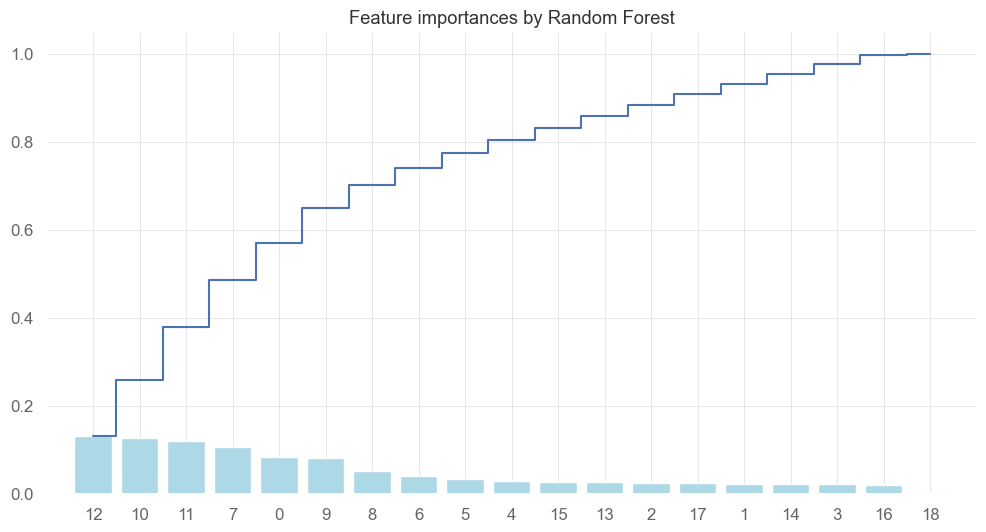

In [46]:
# plot feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by Random Forest")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), indices)
plt.xlim([-1, len(indices)])
plt.show()


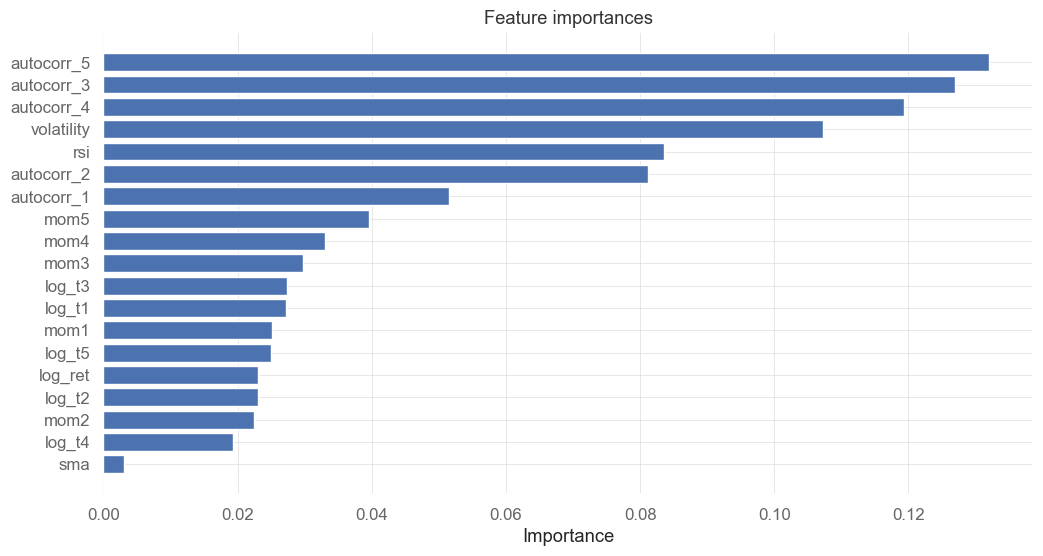

array([18, 16,  3, 14,  1, 17,  2, 13, 15,  4,  5,  6,  8,  9,  0,  7, 11,
       10, 12])

In [47]:
# plot feature importance with feature name
feature_names = X.columns.tolist()
feature_importances = rf.feature_importances_
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()
sorted_idx

In [48]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))
y_train_pred = y_pred

              precision    recall  f1-score   support

           0       0.68      0.60      0.64      2922
           1       0.61      0.69      0.64      2638

    accuracy                           0.64      5560
   macro avg       0.64      0.64      0.64      5560
weighted avg       0.65      0.64      0.64      5560

Confusion Matrix
[[1748 1174]
 [ 824 1814]]

Accuracy
0.6406474820143885


In [49]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))
y_test_pred = y_pred
cm = confusion_matrix(y_test, y_pred)
cm

              precision    recall  f1-score   support

           0       0.52      0.55      0.53       695
           1       0.52      0.50      0.51       696

    accuracy                           0.52      1391
   macro avg       0.52      0.52      0.52      1391
weighted avg       0.52      0.52      0.52      1391

Confusion Matrix
[[380 315]
 [350 346]]

Accuracy
0.5219266714593818


array([[380, 315],
       [350, 346]])

Total return: 1.76
shape daily_rets (205,) time range 2023-01-10 00:00:00 to 2023-08-02 00:00:00
shape benchmark_rets (205,) time range 2023-01-10 00:00:00 to 2023-08-02 00:00:00


                           daily_rets    meta-label-trend
-------------------------  ------------  ------------------
Start Period               2023-01-10    2023-01-10
End Period                 2023-08-02    2023-08-02
Risk-Free Rate             0.0%          0.0%
Time in Market             86.0%         68.0%

Cumulative Return          43.36%        203.94%
CAGR﹪                     56.04%        294.8%

Sharpe                     1.14          1.73
Prob. Sharpe Ratio         84.88%        93.3%
Smart Sharpe               1.09          1.67
Sortino                    1.78          2.53
Smart Sortino              1.71          2.43
Sortino/√2                 1.26          1.79
Smart Sortino/√2           1.21          1.72
Omega                      1.53          1.53

Max Drawdown               -22.31%       -75.51%
Longest DD Days            108           104
Volatility (ann.)          49.77%        160.09%
R^2                        0.0           0.0
Information Ratio          0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-02-08,2023-03-12,2023-03-26,47,-75.513649,-73.678950
2,2023-04-19,2023-04-23,2023-07-31,104,-59.561805,-59.147848
3,2023-01-11,2023-01-15,2023-01-15,5,-10.479889,-10.166607
4,2023-01-19,2023-01-20,2023-01-24,6,-8.721088,-7.002811
5,2023-04-04,2023-04-08,2023-04-08,5,-8.073751,-6.560893


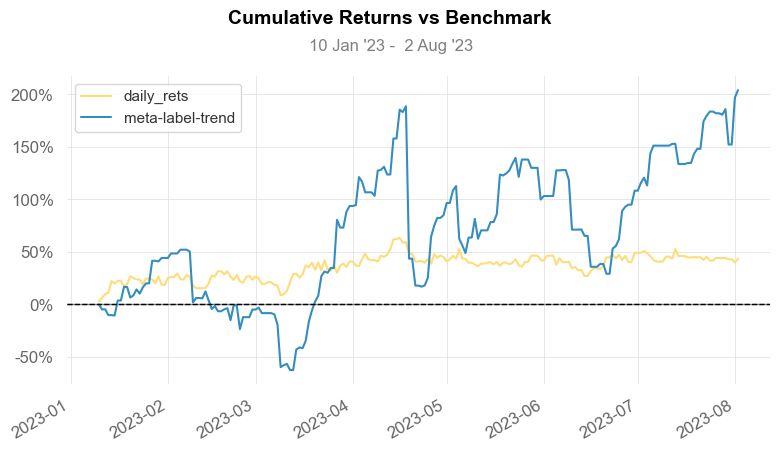

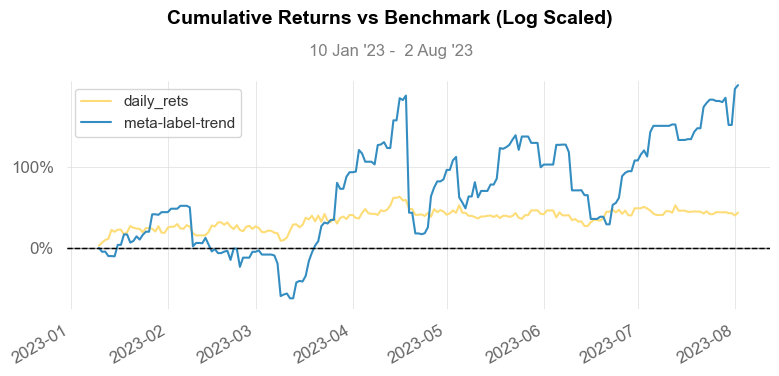

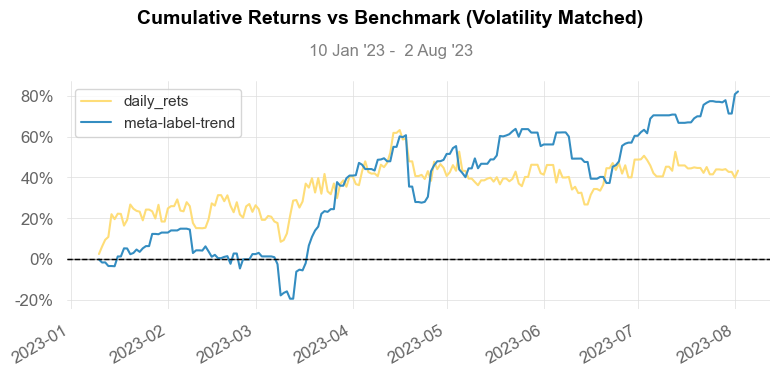

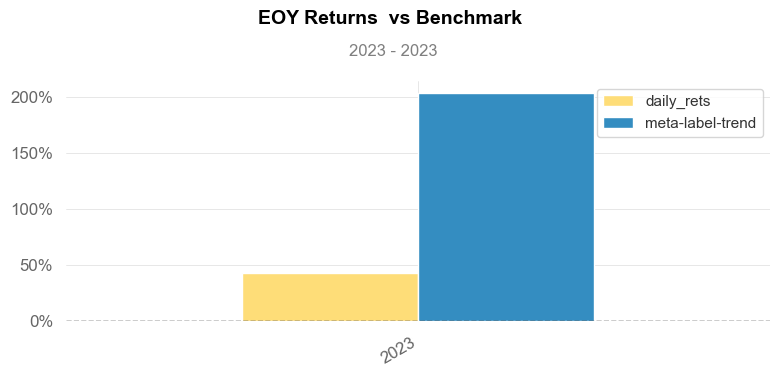

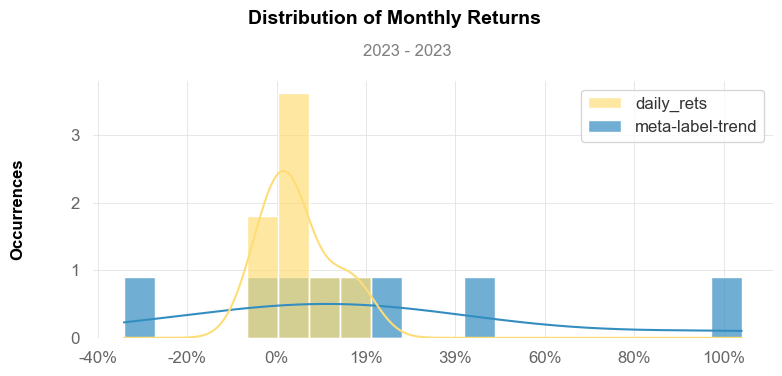

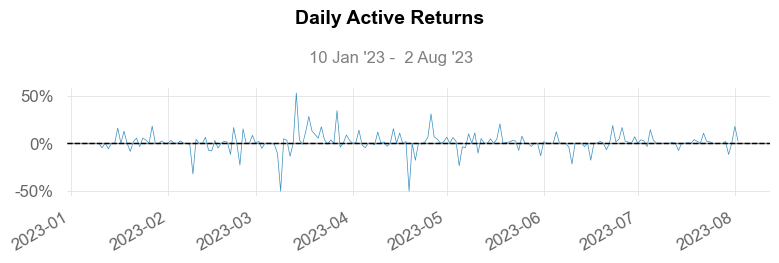

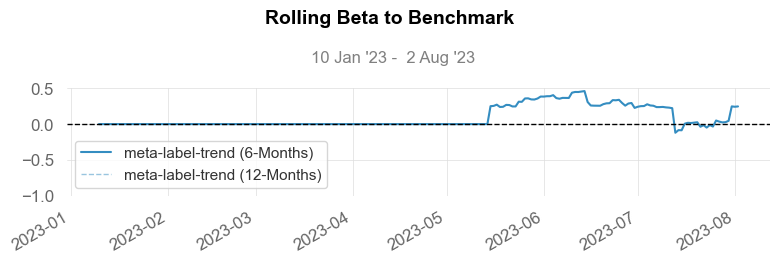

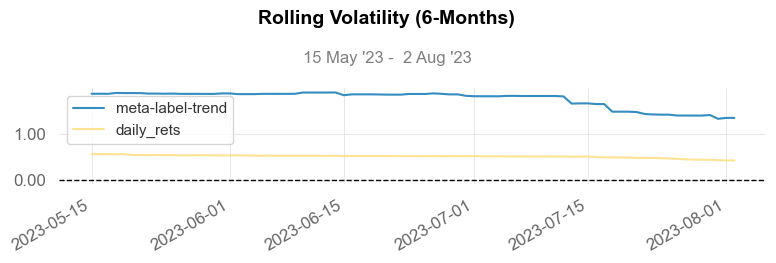

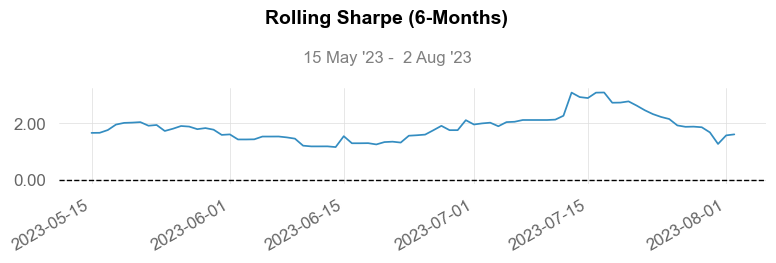

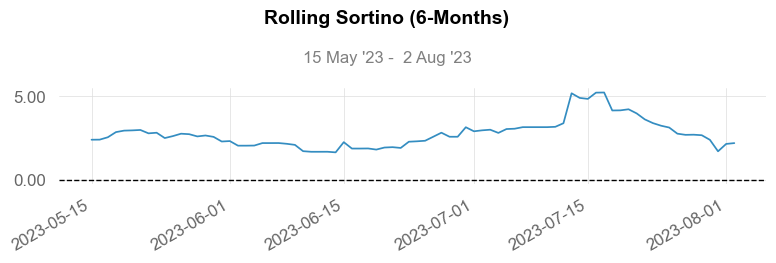

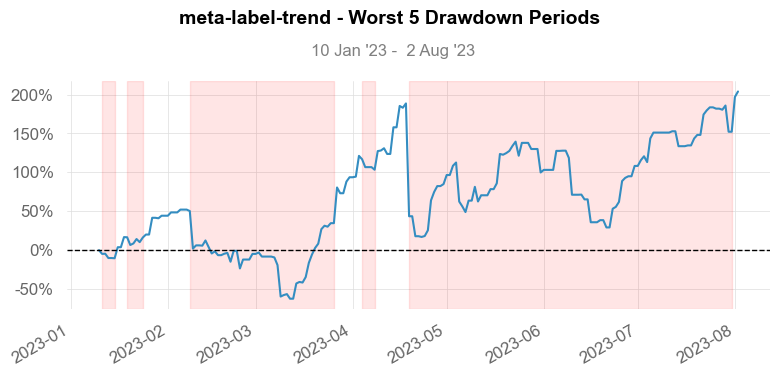

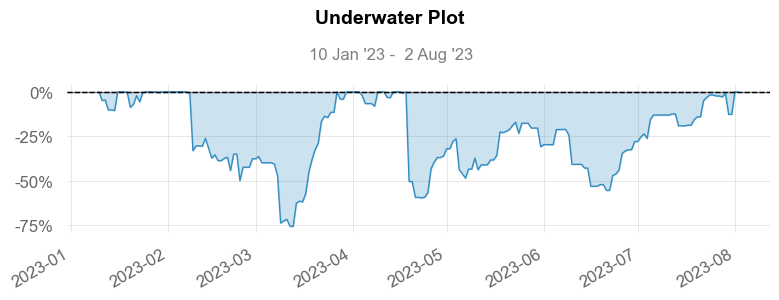

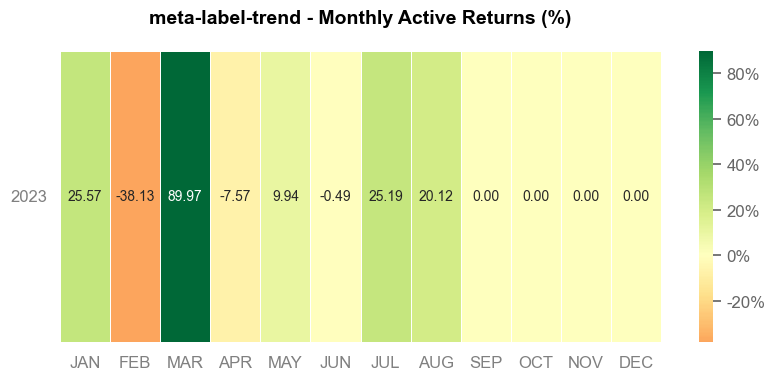

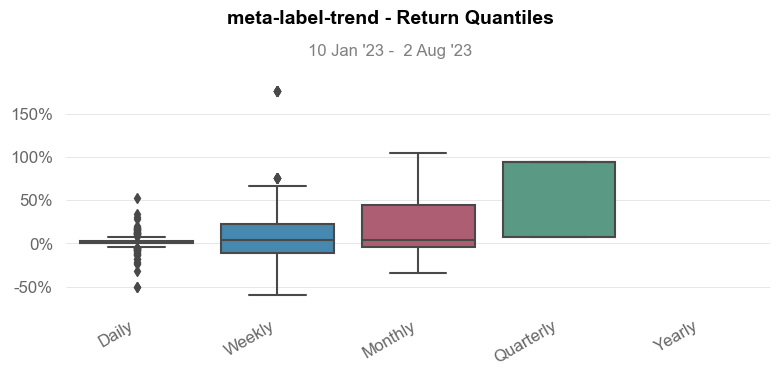

In [50]:
from utils.afml_backtest import *
import imp
imp.reload(sys.modules['utils.afml_backtest']) 

# trade_returns = get_trade_returns(labels,y_test,y_test)
# total_return = compute_total_return(trade_returns)
# print(f"Total return: {total_return:.2f}")
back_test(data,labels,y_test,y_pred,fee=0.0008)